# 3주차 Multilayer perceptron

<img src='https://d2l.ai/_images/mlp.svg'>




## 3.1 Activation function

In [1]:
!pip install --quiet d2l


[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
%matplotlib inline
import torch
from d2l import torch as d2l

### a. ReLU

현재까지 널리 사용되면서, 적용하기 쉬운 비선형 활성화 함수 *rectified linear unit* **(ReLU)** 함수를 그려봅시다.


$$ \texttt{ReLU}(x)=\max\{x, 0\} $$



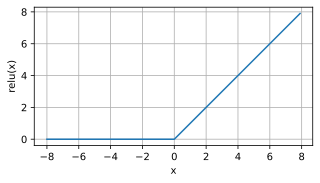

In [20]:
x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = torch.relu(x)
d2l.plot(x.detach(), y.detach(), 'x', 'relu(x)', figsize=(5, 2.5))      #gradient 추적하지 않도록 분리


ReLU 함수의 미분꼴은 *heavyside function* 입니다.

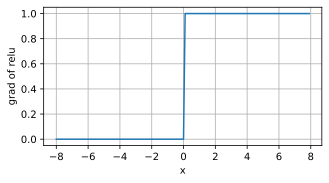

In [21]:
y.backward(torch.ones_like(x), retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of relu', figsize=(5, 2.5))

* ReLU 함수를 직접 구현해봅시다!

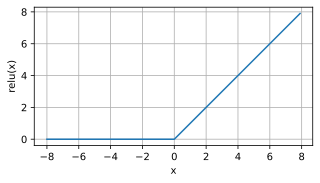

In [18]:
x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = torch.max(torch.zeros_like(x), x)

d2l.plot(x.detach(), y.detach(), 'x', 'relu(x)', figsize=(5, 2.5))

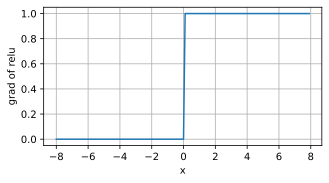

In [22]:
# Clear out previous gradients
x.grad.data.zero_()

y.backward(torch.ones_like(x), retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of relu', figsize=(5, 2.5))

### b. Sigmoid

Sigmoid 함수는 실수 전체 $\mathbb{R}$ 도메인을 $(0, 1)$ 구간으로 맵핑하는 함수입니다.

$$ \texttt{Sigmoid}(x)={1\over 1+\exp(-x)}  $$


기울기 기반 학습 과정에서 sigmoid 는 부드럽고 미분가능한 좋은 성질을 가진 함수입니다.

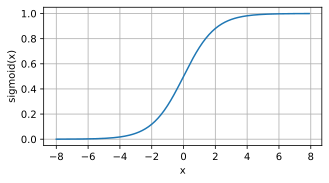

In [23]:
y = torch.sigmoid(x)
d2l.plot(x.detach(), y.detach(), 'x', 'sigmoid(x)', figsize=(5, 2.5))

한편 sigmoid 함수의 미분은 다시 자기자신을 이용한 형태로 나타납니다.

$$ {d\over dx}\texttt{sigmoid}(x)={\exp(-x)\over(1+\exp(-x))^2}=\texttt{sigmoid}(x)(1-\texttt{sigmoid}(x)). $$

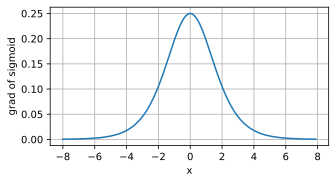

In [24]:
# Clear out previous gradients
x.grad.data.zero_()
y.backward(torch.ones_like(x),retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of sigmoid', figsize=(5, 2.5))

* Sigmoid 함수를 직접 구현해봅시다!

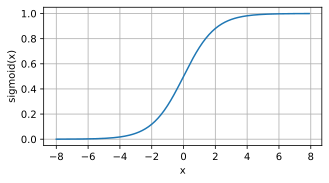

In [25]:
## 빈칸을 채워주세요 ##
y =  1 / (1 + torch.exp(-x))

d2l.plot(x.detach(), y.detach(), 'x', 'sigmoid(x)', figsize=(5, 2.5))

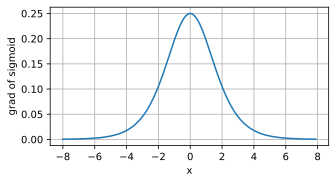

In [26]:
# Clear out previous gradients
x.grad.data.zero_()
y.backward(torch.ones_like(x),retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of sigmoid', figsize=(5, 2.5))

## 3.2 MLP implementation



In [27]:
import torch
from torch import nn, optim
from sklearn.datasets import load_breast_cancer ##, load_digits, load_wine ##

import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

## Step 1. Load dataset

In [28]:
data = load_breast_cancer()

In [29]:
input = data.data
output = data.target

* GPU 사용이 가능하다면 device 를 GPU 로 설정!

In [30]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device == "cuda":
  torch.cuda.manual_seed_all(777)

* 데이터를 미리 설정한 device 로 이동합니다.

In [31]:
## Split datasets
x_train, x_test, y_train, y_test = train_test_split(input, output, test_size = 0.3, random_state = 42, stratify= data.target, shuffle = True)

x_train = torch.FloatTensor(x_train).to(device)
y_train = torch.LongTensor(y_train).to(device)
x_test = torch.FloatTensor(x_test)
y_test = torch.LongTensor(y_test)

## Retrieve length of the inputs
x_len = len(x_train[0])
y_len = len(y_train.unique())

In [32]:
print(x_train[0])
print(y_train[0])

tensor([1.1620e+01, 1.8180e+01, 7.6380e+01, 4.0880e+02, 1.1750e-01, 1.4830e-01,
        1.0200e-01, 5.5640e-02, 1.9570e-01, 7.2550e-02, 4.1010e-01, 1.7400e+00,
        3.0270e+00, 2.7850e+01, 1.4590e-02, 3.2060e-02, 4.9610e-02, 1.8410e-02,
        1.8070e-02, 5.2170e-03, 1.3360e+01, 2.5400e+01, 8.8140e+01, 5.2810e+02,
        1.7800e-01, 2.8780e-01, 3.1860e-01, 1.4160e-01, 2.6600e-01, 9.2700e-02])
tensor(1)


## Step 2 : CustomDataset 과 DataLoader

In [33]:
from torch.utils.data import Dataset

class CustomDataset(Dataset):
  def __init__(self):
    self.x_data = x_train
    self.y_data = [[y] for y in y_train]
#  데이터셋의 전처리를 해주는 부분

  def __len__(self):
    return len(self.x_data)
#  데이터셋의 길이. 즉, 총 샘플의 수를 적어주는 부분

  def __getitem__(self, idx):
    x = torch.FloatTensor(self.x_data[idx]).to(device)
    y = torch.LongTensor(self.y_data[idx]).to(device)
#  데이터셋에서 특정 1개의 샘플을 가져오는 함수

    return x,y

In [34]:
batch_size = 8

dataset = CustomDataset()
dataloader = DataLoader(dataset, batch_size=batch_size)

## Step 3 : Define "Model"

* activation function 이용

  * nn.Sigmoid()
  * nn.ReLU()
  * nn.tanH()


* batch normazliation 1d 란?
  * 파라미터 값으로 vector의 길이를 전해줌



* a. 직접 nn.Sequential() 로 구현하기

In [35]:
# input_layer에 들어가는 최초의 input 크기를 맞춰주자!
# output_layer로 출력되는 마지막 output 의 크기도 마찬가지.

model = nn.Sequential(
          nn.Linear(x_len ,398, bias=True),
          nn.Sigmoid(),
          nn.Linear(398, 15, bias=True),
          nn.Sigmoid(),
          nn.Linear(15, y_len, bias=True),
          nn.Softmax()
          ).to(device)

* b. 파이썬 Class 로 구현하기

In [36]:
class Model(torch.nn.Module):

  def __init__(self):
    super(Model, self).__init__()
    self.layer1 = nn.Sequential(
          nn.Linear(x_len ,398, bias=True), # input_layer = 30, hidden_layer1 = 398
          nn.Sigmoid(),
        nn.BatchNorm1d(398)
    )
    self.layer2 = nn.Sequential(
          nn.Linear(398, 15, bias=True), # hidden_layer1 = 398, hidden_layer2 = 15
        nn.Sigmoid()
    )
    self.layer3 = nn.Sequential(
          nn.Linear(15, 10, bias=True), # hidden_layer1 = 15, hidden_layer2 = 10
        nn.Sigmoid()
    )
    self.layer4 = nn.Sequential(
        nn.Linear(10, y_len, bias=True), # hidden_layer3 = 10, output_layer = 2
        nn.Softmax()
    )

  def forward(self,x):
    output = self.layer1(x)
    output = self.layer2(output)
    output = self.layer3(output)
    output = self.layer4(output)
    return output

* Weight initialization

In [37]:
def init_weights(layer):
    if isinstance(layer, nn.Linear):                    #layer가 nn.Linear(완전연결층)인지 확인
        torch.nn.init.xavier_uniform(layer.weight)      #Xavier 초기화 방식으로 초기화 -> 입력과 출력의 분산이 동일하게 유지되도록 가중치를 설정(균등분포 샘플링)
        layer.bias.data.fill_(0.01)                     #모든 편향 값 1로 초기화

In [38]:
model = Model().to(device)
model.apply(init_weights)

print(model)

Model(
  (layer1): Sequential(
    (0): Linear(in_features=30, out_features=398, bias=True)
    (1): Sigmoid()
    (2): BatchNorm1d(398, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=398, out_features=15, bias=True)
    (1): Sigmoid()
  )
  (layer3): Sequential(
    (0): Linear(in_features=15, out_features=10, bias=True)
    (1): Sigmoid()
  )
  (layer4): Sequential(
    (0): Linear(in_features=10, out_features=2, bias=True)
    (1): Softmax(dim=None)
  )
)


C:\Users\장건호\AppData\Local\Temp\ipykernel_59616\2561401709.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(layer.weight)


## Step 4 : Loss function 과 Optimizer

* 다양한 optimizer 가 존재
  * https://pytorch.org/docs/stable/optim.html#module-torch.optim 페이지 참조

In [39]:
loss_fn  = nn.CrossEntropyLoss().to(device)

In [40]:
optimizer = optim.Adam(model.parameters(), lr= 0.01)

## Step 5: Train Model

In [41]:
losses = []
for epoch in range(100):

  optimizer.zero_grad()
  hypothesis = model(x_train)

  # 비용 함수
  cost = loss_fn(hypothesis, y_train)
  cost.backward()
  optimizer.step()
  losses.append(cost.item())

  if epoch % 10 == 0:
    print(epoch, cost.item())

c:\Python311\Lib\site-packages\torch\nn\modules\module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


0 0.6551404595375061
10 0.5053728818893433
20 0.4216148853302002
30 0.3933706283569336
40 0.391283243894577
50 0.38408276438713074
60 0.37728917598724365
70 0.3776780962944031
80 0.3877958357334137
90 0.3830651640892029


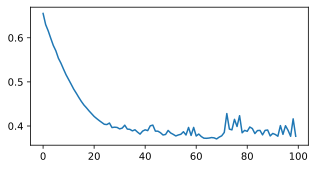

In [42]:
plt.plot(losses)
plt.show()

In [43]:
with torch.no_grad():
  model = model.to('cpu')
  y_pred = model(x_test)
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))

In [44]:
print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'accuracy는 {accuracy}')

model의 output은 :  [0.00352371 0.99647623]
argmax를 한 후의 output은 1
accuracy는 0.9122807017543859


# MLP 를 다뤄봅시다!

위 코드를 참고하여 직접 MLP 를 구현해봅시다.

load_digits() 또는 load_wine() 중 하나를 골라 시도해보세요!

- lr, optimizer, hidden layer(depth), neuron 수(width)를 바꾸기
- 전처리도 추가
- 모든 시도를 올려주세요!
- 제일 높은 acc를 보인 시도를 명시해주세요!

In [95]:
from sklearn.datasets import
## load_digits, load_wine

SyntaxError: invalid syntax (1445799879.py, line 1)

In [41]:
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [164]:
# Load wine dataset
data = load_wine()

In [165]:
input = data.data
output = data.target

In [166]:
import pandas as pd

df_input = pd.DataFrame(input)
df_input

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95.0,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740.0
174,13.40,3.91,2.48,23.0,102.0,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750.0
175,13.27,4.28,2.26,20.0,120.0,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835.0
176,13.17,2.59,2.37,20.0,120.0,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840.0


In [13]:
df_output = pd.DataFrame(output)
df_output

,0
0,0
1,0
2,0
3,0
4,0
...,...
173,2
174,2
175,2
176,2


In [167]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device == "cuda":
  torch.cuda.manual_seed_all(777)

In [168]:
# Split datasets
x_train, x_test, y_train, y_test = train_test_split(input, output, test_size=0.3, random_state=42, stratify=output, shuffle=True)


In [169]:
# Standardize the data
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

x_train = torch.FloatTensor(x_train).to(device)
y_train = torch.LongTensor(y_train).to(device)
x_test = torch.FloatTensor(x_test)
y_test = torch.LongTensor(y_test)


In [170]:
# Retrieve length of the inputs
x_len = x_train.shape[1]
y_len = len(torch.unique(y_train))

print(x_train[0])
print(y_train[0])

tensor([ 0.9827, -0.5276,  0.1736, -1.0875, -0.7277,  0.4915,  0.7915, -0.5967,
         0.3546,  0.2554,  0.8575,  0.4378,  1.8632])
tensor(0)


In [171]:
class CustomDataset(Dataset):
  def __init__(self):
    self.x_data = x_train
    self.y_data = [[y] for y in y_train]

  def __len__(self):
    return len(self.x_data)

  def __getitem__(self, idx):
    x = self.x_data[idx]
    y = torch.LongTensor(self.y_data[idx])
    return x, y

batch_size = 8
dataset = CustomDataset()
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [172]:
#1
class Model(nn.Module):
  def __init__(self):
    super(Model, self).__init__()
    self.layer1 = nn.Sequential(
          nn.Linear(x_len, 512, bias=True),
          nn.ReLU(),
          nn.BatchNorm1d(512)
    )
    self.layer2 = nn.Sequential(
          nn.Linear(512, 256, bias=True),
          nn.ReLU(),
          nn.BatchNorm1d(256)
    )
    self.layer3 = nn.Sequential(
          nn.Linear(256, 128, bias=True),
          nn.ReLU(),
          nn.BatchNorm1d(128)
    )
    self.layer4 = nn.Sequential(
        nn.Linear(128, y_len, bias=True),
        nn.Softmax(dim=1)
    )

  def forward(self, x):
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)
    return x


In [173]:
#2
class Model(nn.Module):
  def __init__(self):
    super(Model, self).__init__()
    self.layer1 = nn.Sequential(
          nn.Linear(x_len, 256, bias=True),
          nn.ReLU(),
          nn.BatchNorm1d(256)
    )
    self.layer2 = nn.Sequential(
          nn.Linear(256, 128, bias=True),
          nn.ReLU(),
          #nn.BatchNorm1d(128)
    )
    self.layer3 = nn.Sequential(
          nn.Linear(128, 64, bias=True),
          nn.ReLU(),
          #nn.BatchNorm1d(64)
    )
    self.layer4 = nn.Sequential(
        nn.Linear(64, y_len, bias=True),
        nn.Softmax(dim=1)
    )

  def forward(self, x):
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)
    return x

In [174]:
def init_weights(layer):
    if isinstance(layer, nn.Linear):
        torch.nn.init.xavier_uniform_(layer.weight)
        layer.bias.data.fill_(0.01)

In [175]:
model = Model().to(device)
model.apply(init_weights)

print(model)

Model(
  (layer1): Sequential(
    (0): Linear(in_features=13, out_features=256, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
  )
  (layer3): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
  )
  (layer4): Sequential(
    (0): Linear(in_features=64, out_features=3, bias=True)
    (1): Softmax(dim=1)
  )
)


In [176]:
loss_fn = nn.CrossEntropyLoss().to(device)

In [177]:
#1
# optimizer = optim.Adam(model.parameters(), lr=0.01)
#2
optimizer = optim.Adam(model.parameters(), lr=0.0001)
#3
#optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)


In [178]:
losses = []
for epoch in range(100):
  model.train()
  optimizer.zero_grad()
  hypothesis = model(x_train)
  cost = loss_fn(hypothesis, y_train)
  cost.backward()
  optimizer.step()
  losses.append(cost.item())

  if epoch % 10 == 0:
    print(f'Epoch {epoch}, Cost: {cost.item()}')

Epoch 0, Cost: 1.137435793876648
Epoch 10, Cost: 0.9867433309555054
Epoch 20, Cost: 0.8610718846321106
Epoch 30, Cost: 0.7623690962791443
Epoch 40, Cost: 0.6933032274246216
Epoch 50, Cost: 0.647445559501648
Epoch 60, Cost: 0.6178176403045654
Epoch 70, Cost: 0.5991342663764954
Epoch 80, Cost: 0.587250292301178
Epoch 90, Cost: 0.5792946219444275


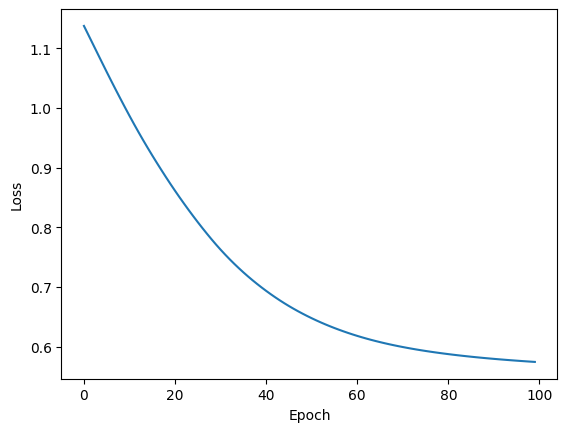

In [179]:
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [180]:
with torch.no_grad():
  model = model.to('cpu')
  y_pred = model(x_test)
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis=1)
  accuracy = accuracy_score(predicted, y_test)

In [181]:
print(f'Model output: {y_pred[0]}')
print(f'Argmax output: {predicted[0]}')
print(f'Accuracy: {accuracy * 100:.2f}%')

Model output: [0.88707495 0.07760128 0.03532382]
Argmax output: 0
Accuracy: 98.15%


# 전처리



In [94]:
df_input.isnull().sum()

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
dtype: int64

In [182]:
# Load wine dataset
data = load_wine()
input = data.data
output = data.target

# 데이터프레임으로 변환
df = pd.DataFrame(input, columns=data.feature_names)
df['target'] = output

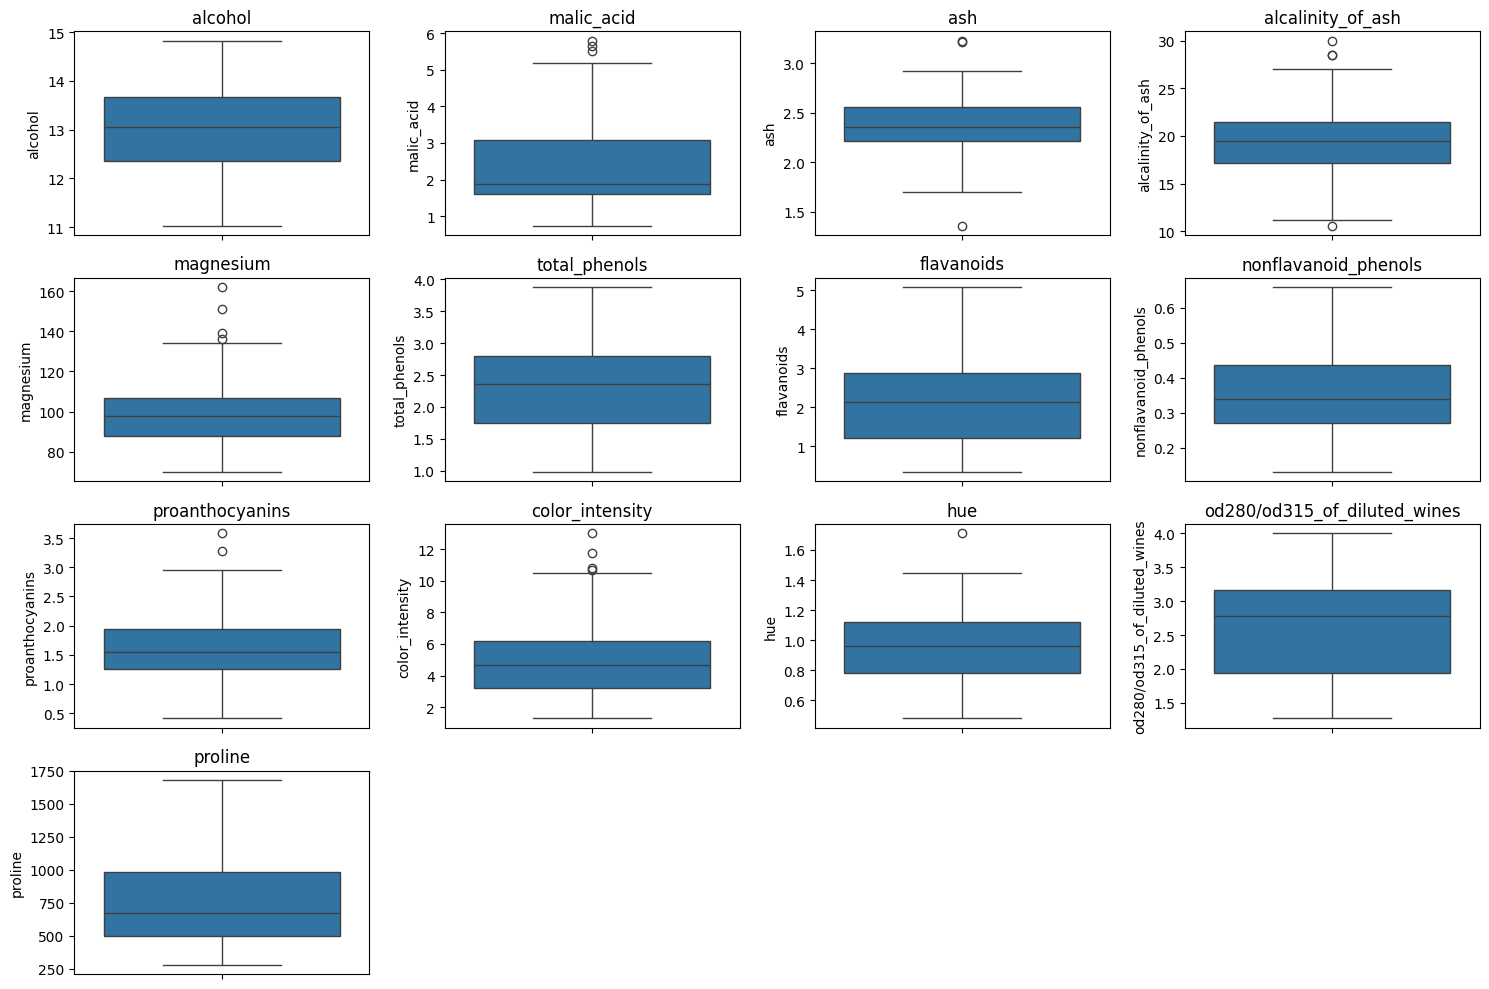

In [183]:
# IQR 방식으로 이상치 처리하기 전 box plot 그리기
import seaborn as sns

plt.figure(figsize=(15, 10))
for i, column in enumerate(df.columns[:-1], 1):
    plt.subplot(4, 4, i)
    sns.boxplot(y=df[column])
    plt.title(column)
plt.tight_layout()
plt.show()

In [184]:
# IQR 방식으로 이상치 처리
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
df = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]

print('Original data shape:', input.shape)
print('Data shape after outlier removal:', df.shape)

Original data shape: (178, 13)
Data shape after outlier removal: (161, 14)


In [185]:
# 이상치 제거 후 input과 output 분리
input_o = df.drop(columns=['target']).values
output_o = df['target'].values

In [186]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device == "cuda":
    torch.cuda.manual_seed_all(777)

In [187]:
# Split datasets
x_train, x_test, y_train, y_test = train_test_split(input_o, output_o, test_size=0.3, random_state=42, stratify=output_o, shuffle=True)

In [188]:
# Standardize the data
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test= scaler.transform(x_test)

x_train = torch.FloatTensor(x_train).to(device)
y_train = torch.LongTensor(y_train).to(device)
x_test = torch.FloatTensor(x_test).to(device)
y_test = torch.LongTensor(y_test).to(device)

In [189]:
# Retrieve length of the inputs
x_len = x_train.shape[1]
y_len = len(torch.unique(y_train))

print(x_train[0])
print(y_train[0])

tensor([ 0.7839, -0.4547, -0.0671, -0.7144,  0.4198,  0.2832,  0.7198,  0.5545,
         0.9077, -0.5325,  1.2417,  0.3798,  0.6980])
tensor(0)


In [190]:
class CustomDataset(Dataset):
    def __init__(self, x_data, y_data):
        self.x_data = torch.FloatTensor(x_data)
        self.y_data = torch.LongTensor(y_data)

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        x = self.x_data[idx]
        y = self.y_data[idx]
        return x, y

batch_size = 8
train_dataset = CustomDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = CustomDataset(x_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [191]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(x_len, 256, bias=True),  # input_layer = x_len, hidden_layer1 = 256
            nn.Sigmoid(),
            nn.BatchNorm1d(256)
        )
        self.layer2 = nn.Sequential(
            nn.Linear(256, 128, bias=True),  # hidden_layer1 = 256, hidden_layer2 = 128
            nn.Sigmoid()
        )
        self.layer3 = nn.Sequential(
            nn.Linear(128, 64, bias=True),  # hidden_layer2 = 128, hidden_layer3 = 64
            nn.Sigmoid()
        )
        self.layer4 = nn.Sequential(
            nn.Linear(64, y_len, bias=True),  # hidden_layer3 = 64, output_layer = y_len
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        return x




In [192]:
def init_weights(layer):
    if isinstance(layer, nn.Linear):
        torch.nn.init.xavier_uniform_(layer.weight)
        layer.bias.data.fill_(0.01)


In [193]:
model = Model().to(device)
model.apply(init_weights)

print(model)

Model(
  (layer1): Sequential(
    (0): Linear(in_features=13, out_features=256, bias=True)
    (1): Sigmoid()
    (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): Sigmoid()
  )
  (layer3): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): Sigmoid()
  )
  (layer4): Sequential(
    (0): Linear(in_features=64, out_features=3, bias=True)
    (1): Softmax(dim=1)
  )
)


In [194]:
loss_fn = nn.CrossEntropyLoss().to(device)

In [195]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
#optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [196]:
losses = []
for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    hypothesis = model(x_train)
    cost = loss_fn(hypothesis, y_train)
    cost.backward()
    optimizer.step()
    losses.append(cost.item())

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Cost: {cost.item()}')


Epoch 0, Cost: 1.1052740812301636
Epoch 10, Cost: 0.8445050120353699
Epoch 20, Cost: 0.6917961239814758
Epoch 30, Cost: 0.62192302942276
Epoch 40, Cost: 0.592185378074646
Epoch 50, Cost: 0.5775391459465027
Epoch 60, Cost: 0.5698302984237671
Epoch 70, Cost: 0.5653908848762512
Epoch 80, Cost: 0.5625553131103516
Epoch 90, Cost: 0.5606048703193665


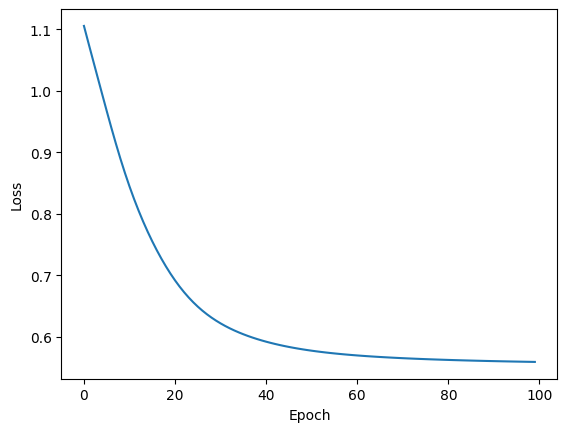

In [197]:
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


In [198]:
with torch.no_grad():
    model = model.to('cpu')
    y_pred = model(x_test)
    y_pred = y_pred.detach().numpy()
    predicted = np.argmax(y_pred, axis=1)
    accuracy = accuracy_score(predicted, y_test)

In [199]:
print(f'Model output: {y_pred[0]}')
print(f'Argmax output: {predicted[0]}')
print(f'Accuracy: {accuracy * 100:.2f}%')


Model output: [0.00210635 0.99384874 0.00404485]
Argmax output: 1
Accuracy: 100.00%
